# Junction metrics analysis

In this notebook we will explore the discriminative power of the different metrics developed to filter junctions extracted from nanopore DRS read alignments, using data simulated from Arabidopsis and human nanopore DRS read alignments and the AtRTD2 and GRCh38 reference annotations

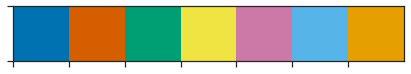

In [1]:
import sys
import re
import os
from glob import glob
import random

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, rgb2hex
import seaborn as sns

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

import sklearn

## Default plotting params

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=1.4, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7', '#56b4e9', '#e69f00'])
cmap = ListedColormap(pal.as_hex())
sns.set_palette(pal)
sns.palplot(pal)
div_cmap = sns.diverging_palette(245, 26, s=99, l=50, sep=1, as_cmap=True)
plt.show()

In [2]:
COLUMNS = [
    'chrom', 'start', 'end', 'motif', 'count', 'strand',
    'jad', 'is_primary_donor', 'is_primary_acceptor',
    'decision1', 'donor_seq_score', 'acceptor_seq_score',
    'decision2'
]

def load_juncs(basename, sim=True):

    annotated_introns = pd.read_csv(
        f'../pipeline/{basename}/juncs/annot_juncs.bed', sep='\t', names=COLUMNS[:6],
        dtype={'chrom': str}
    )[['chrom', 'start', 'end', 'strand']].drop_duplicates()
    annotated_introns = set(tuple(inv) for inv in annotated_introns.itertuples(index=False))


    real_or_sim = 'real' if not sim else 'sim_nofrag'
    
    juncs = {}
    for first_pass_fn in glob(f'../pipeline/{basename}/*/juncs/*.{real_or_sim}.all.bed'):
        sample_name = first_pass_fn.split('/')[3]
        j = pd.read_csv(first_pass_fn, sep='\t', names=COLUMNS, dtype={'chrom': str})
        j['is_annot'] = [
            int(tuple(inv) in annotated_introns)
            for inv in j[['chrom', 'start', 'end', 'strand']].itertuples(index=False)
        ]
        j['intron_length'] = j.end - j.start
        j['is_canon'] = j.motif.str.match('GTAG|GCAG|ATAG').astype(int)
        j['jad_thresholded'] = j.jad >= 4
        j = j.set_index(['chrom', 'start', 'end', 'strand'])
        juncs[sample_name] = j

    juncs = pd.concat(juncs)
    return juncs

arath_juncs = load_juncs('arabidopsis_drs', sim=True)
arath_real_juncs = load_juncs('arabidopsis_drs', sim=False)
arath_juncs.head()

motif  \
                                                  chrom start end  strand         
20180418_1428_20180418_FAH83552_mRNA_WT_Col0_2919 1     3913  4000 +       GTAG   
                                                        4276  4485 +       GTAG   
                                                        4605  4705 +       GTAG   
                                                        5095  5173 +       GTAG   
                                                        5326  5438 +       GTAG   

                                                                           count  \
                                                  chrom start end  strand          
20180418_1428_20180418_FAH83552_mRNA_WT_Col0_2919 1     3913  4000 +           2   
                                                        4276  4485 +           3   
                                                        4605  4705 +           3   
                                                        5095  5173 +           3   
                                                        5326  5438 +           3   

                                                                           jad  \
                                                  chrom start end  strand        
20180418_1428_20180418_FAH83552_mRNA_WT_Col0_2919 1     3913  4000 +         1   
                                                        4276  4485 +         4   
                                                        4605  4705 +        30   
                                                        5095  5173 +         6   
                                                        5326  5438 +        15   

                                                                           is_primary_donor  \
                                                  chrom start end  strand                     
20180418_1428_20180418_FAH83552_mRNA_WT_Col0_2919 1     3913  4000 +                      1   
                                                        4276  4485 +                      1   
                                                        4605  4705 +                      1   
                                                        5095  5173 +                      1   
                                                        5326  5438 +                      1   

                                                                           is_primary_acceptor  \
                                                  chrom start end  strand                        
20180418_1428_20180418_FAH83552_mRNA_WT_Col0_2919 1     3913  4000 +                         1   
                                                        4276  4485 +                         1   
                                                        4605  4705 +                         1   
                                                        5095  5173 +                         1   
                                                        5326  5438 +                         1   

                                                                           decision1  \
                                                  chrom start end  strand              
20180418_1428_20180418_FAH83552_mRNA_WT_Col0_2919 1     3913  4000 +               1   
                                                        4276  4485 +               1   
                                                        4605  4705 +               1   
                                                        5095  5173 +               1   
                                                        5326  5438 +               1   

                                                                           donor_seq_score  \
                                                  chrom start end  strand                    
20180418_1428_20180418_FAH83552_mRNA_WT_Col0_2919 1     3913  4000 +                 0.913   
                                                        4276  4485 +        

In [3]:
features = [
    'count',
    'is_primary_donor', 'is_primary_acceptor',
    'jad_thresholded', 'is_canon'
]

feature_names = [
    'Read count',
    'Primary donor', 'Primary acceptor',
    'JAD', 'Canonical splice'
]

X_arath = arath_juncs[features].values.astype(float)
y_arath = arath_juncs.is_annot.values.astype(int)

We can use an extremely random forest classifier to assess the "importance" of features as a measure of how predictive they are:

In [4]:
rf = ExtraTreesClassifier(n_estimators=100, bootstrap=True, oob_score=True).fit(X_arath, y_arath)
feature_importances = pd.Series(rf.feature_importances_, index=feature_names)

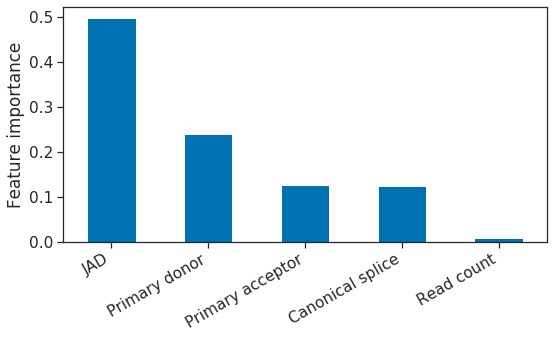

In [5]:
fig, ax = plt.subplots(figsize=(8, 5))
feature_importances.sort_values(ascending=False).plot.bar(color=pal[0], ax=ax)
ax.set_ylabel('Feature importance')
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
plt.tight_layout()
plt.savefig('figures/feature_importances.svg')
plt.show()

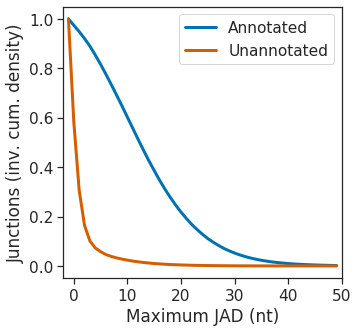

In [6]:
fig, ax = plt.subplots(figsize=(5, 5))

def get_inv_cum_density(arr, bins, range_):
    d, bin_edges = np.histogram(arr, range=range_, bins=bins)
    ics = 1 - (np.cumsum(d) / len(arr))
    return bin_edges[:-1], ics

ax.plot(
    *get_inv_cum_density(arath_juncs.query('is_annot == 1').jad,
                         bins=51, range_=(-1, 50)),
    label='Annotated', lw=3
)

ax.plot(
    *get_inv_cum_density(arath_juncs.query('is_annot == 0').jad,
                         bins=51, range_=(-1, 50)),
    label='Unannotated', lw=3
)


ax.set_xlim(-2, 50)
ax.set_xlabel('Maximum JAD (nt)')
ax.set_ylabel('Junctions (inv. cum. density)')
ax.legend(loc=0)

plt.savefig('figures/jad_annot_vs_unannot.svg')
plt.show()

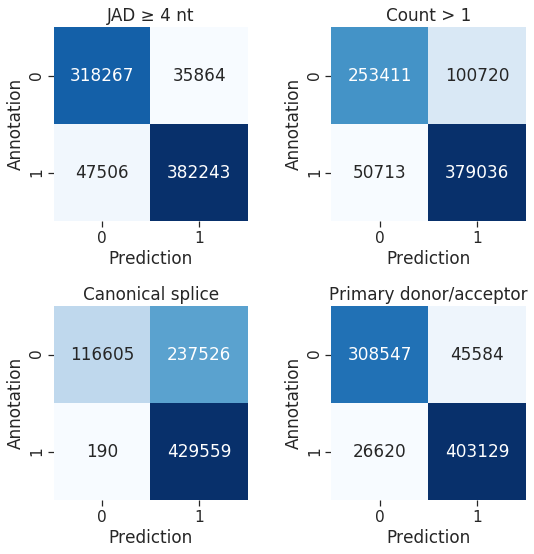

In [7]:
jad4 = pd.crosstab(arath_juncs.is_annot, arath_juncs['jad'] >= 4)
count1 = pd.crosstab(arath_juncs.is_annot, arath_juncs['count'] > 1)
canon_splice = pd.crosstab(arath_juncs.is_annot, arath_juncs.is_canon)
is_primary = pd.crosstab(arath_juncs.is_annot, arath_juncs.is_primary_donor & arath_juncs.is_primary_acceptor)

fig, axes = plt.subplots(figsize=(8, 8), ncols=2, nrows=2)

sns.heatmap(jad4, ax=axes[0][0], cmap='Blues', square=True, cbar=False, annot=True, fmt='d')
axes[0][0].set_xticklabels([0, 1])
axes[0][0].set_yticklabels([0, 1])
axes[0][0].set_title('JAD ≥ 4 nt')
axes[0][0].set_xlabel('Prediction')
axes[0][0].set_ylabel('Annotation')

sns.heatmap(count1, ax=axes[0][1], cmap='Blues', square=True, cbar=False, annot=True, fmt='d')
axes[0][1].set_xticklabels([0, 1])
axes[0][1].set_yticklabels([0, 1])
axes[0][1].set_title('Count > 1')
axes[0][1].set_xlabel('Prediction')
axes[0][1].set_ylabel('Annotation')

sns.heatmap(canon_splice, ax=axes[1][0], cmap='Blues', square=True, cbar=False, annot=True, fmt='d')
axes[1][0].set_xticklabels([0, 1])
axes[1][0].set_yticklabels([0, 1])
axes[1][0].set_title('Canonical splice')
axes[1][0].set_xlabel('Prediction')
axes[1][0].set_ylabel('Annotation')

sns.heatmap(is_primary, ax=axes[1][1], cmap='Blues', square=True, cbar=False, annot=True, fmt='d')
axes[1][1].set_xticklabels([0, 1])
axes[1][1].set_yticklabels([0, 1])
axes[1][1].set_title('Primary donor/acceptor')
axes[1][1].set_xlabel('Prediction')
axes[1][1].set_ylabel('Annotation')

plt.tight_layout()
plt.savefig('figures/individual_metric_confusion_matrices.svg')
plt.show()

In [8]:
jad4.iloc[1, 1] / jad4.iloc[1].sum()

0.8894564036216489

In [9]:
jad4.iloc[0, 1] / jad4.iloc[0].sum()

0.10127325763629844

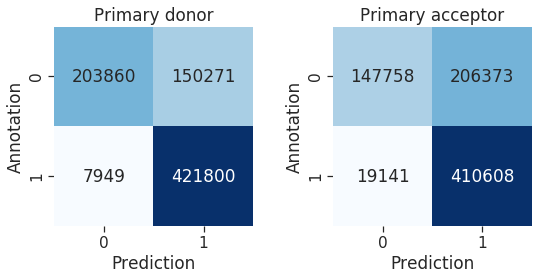

In [10]:
fig, axes = plt.subplots(figsize=(8, 4), ncols=2)

don = pd.crosstab(arath_juncs.is_annot, arath_juncs.is_primary_donor)
acc = pd.crosstab(arath_juncs.is_annot, arath_juncs.is_primary_acceptor)

sns.heatmap(don, ax=axes[0], cmap='Blues', square=True, cbar=False, annot=True, fmt='d')
axes[0].set_xticklabels([0, 1])
axes[0].set_yticklabels([0, 1])
axes[0].set_title('Primary donor')
axes[0].set_xlabel('Prediction')
axes[0].set_ylabel('Annotation')

sns.heatmap(acc, ax=axes[1], cmap='Blues', square=True, cbar=False, annot=True, fmt='d')
axes[1].set_xticklabels([0, 1])
axes[1].set_yticklabels([0, 1])
axes[1].set_title('Primary acceptor')
axes[1].set_xlabel('Prediction')
axes[1].set_ylabel('Annotation')
plt.tight_layout()
plt.savefig('figures/primary_donor_acceptor_metric_confusion_matrices.svg')
plt.show()

In [11]:
da = arath_juncs.is_primary_donor & arath_juncs.is_primary_acceptor
print(
    f'JAD metric F1 score: {f1_score(arath_juncs.is_annot, arath_juncs.jad >= 4):.3f}\n',
    f'JAD metric F1 score (real junctions): {f1_score(arath_real_juncs.is_annot, arath_real_juncs.jad >= 4):.3f}\n',
    f'Read count F1 score: {f1_score(arath_juncs.is_annot, arath_juncs["count"] > 1):.3f}\n',
    f'Canonical splice F1 score: {f1_score(arath_juncs.is_annot, arath_juncs.is_canon):.3f}\n',
    f'Primary donor metric F1 score: {f1_score(arath_juncs.is_annot, arath_juncs.is_primary_donor):.3f}\n',
    f'Primary acceptor metric F1 score: {f1_score(arath_juncs.is_annot, arath_juncs.is_primary_acceptor):.3f}\n',
    f'Primary donor/acceptor metric F1 score: {f1_score(arath_juncs.is_annot, da):.3f}\n',
)

JAD metric F1 score: 0.902
 JAD metric F1 score (real junctions): 0.899
 Read count F1 score: 0.833
 Canonical splice F1 score: 0.783
 Primary donor metric F1 score: 0.842
 Primary acceptor metric F1 score: 0.785
 Primary donor/acceptor metric F1 score: 0.918



In [12]:
stats.spearmanr(arath_juncs.jad, arath_juncs['count'])

SpearmanrResult(correlation=0.7760274264536546, pvalue=0.0)

In [13]:
is_canon_count = arath_juncs.query('is_annot == 1').is_canon.value_counts()

is_canon_count[1] / is_canon_count.sum()

0.9995578814610389

In [14]:
is_not_canon_count = arath_juncs.query('is_annot == 0').is_canon.value_counts()

is_not_canon_count[1] / is_not_canon_count.sum()

0.6707291934340682

The JAD metric is defined as the shortest distance on either overhang of a junction read alignment to the nearest basecall or alignment error. For each junction the best (i.e. largest) individual read JAD is taken. For Arabidopsis and human, the canonical splice metric is simply whether the intron has a GU/AG, GC/AG or AU/AG motif. The primary donor and acceptor metrics are calculated by identifying alternative donor or acceptor sites in a 20 nt window around a given donor/acceptor, and seeing whether they have greater read support than the current site. In cases of ties for read support (i.e. if all junctions have a read count of 1) the JAD is used to break the tie, i.e. the junction with the largest JAD is considered the primary.

The JAD is the most discriminative individual metric using a threshold of >=4 nt, with an F1 score of 0.904. The read count is also predictive at a threshold of >1 read (F1 score 0.841), but is highly correlated with the JAD (spearman rho 0.778) suggesting it does not provide much information beyond what the JAD is able to provide. The canonical intron motif has a very high recall as 99.95% of annotated introns in the dataset are canonical. However, its precision is much poorer, resulting in an F1 score of 0.799. This is because in spliced alignment mode, minimap2 prefers GU/AG motifs, meaning that 68% of spurious junctions are also at canonical motifs. Finally, the primary donor and acceptor metrics are also predictive, with F1 scores of 0.857 and 0.800 respectively. By filtering for junctions which are both primary donors and acceptors, the F1 score can be increased to 0.922. It is unclear why the primary donor score is more predictive than the primary acceptor score. This may be because minimap2 is more likely to produce alignment errors at the donor site of junctions (e.g. in the case of failure to align small internal exons), or because there are more genuine alternative acceptor sites than donor sites.

### Producing decision tree models:

We chose to use a shallow decision tree model to filter the data as these are easy to interpret and reimplement as a set of rules, and should not overfit to the data:

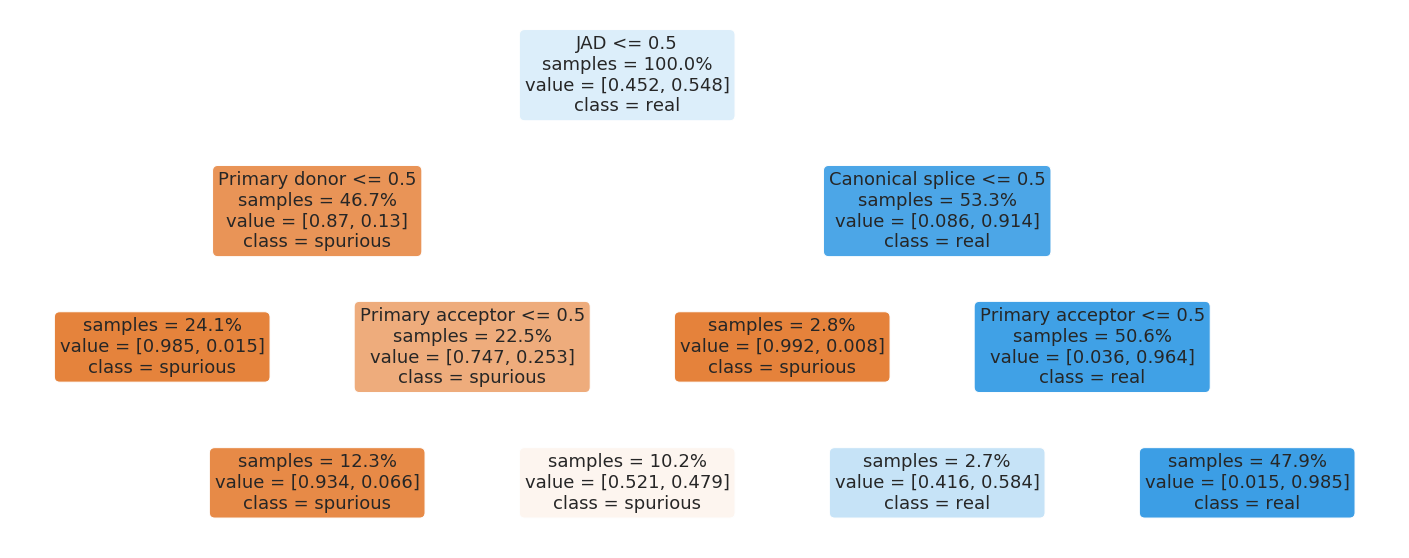

In [15]:
dt_arath = DecisionTreeClassifier(
    max_depth=4,
    min_samples_split=1000,
    min_impurity_decrease=0.005,
).fit(X_arath, y_arath)

fig, ax = plt.subplots(figsize=(25, 10))
plot_tree(
    dt_arath,
    ax=ax,
    fontsize=18,
    feature_names=feature_names,
    filled=True,
    rounded=True,
    impurity=False,
    proportion=True,
    precision=3,
    class_names=['spurious', 'real']
)
plt.show()

This tree was simplified by pruning splits which do not alter the overall decision, to give the following overall tree structure:


In [16]:
dt1_rules = [
    'jad >= 4',
    [
        'is_primary_donor == 1',
        0,
        [
            'is_primary_acceptor == 1',
            0,
            [
                'is_canon == 1',
                0,
                1,
            ],
        ],
    ],
    [
        'is_canon == 1',
        0,
        1,
    ],
]

def rule_string(rule, y_true, total_size, class_names):
    p_tot = len(y_true) / total_size * 100
    p_true = sum(y_true) / len(y_true) * 100
    p_false = 100 - p_true
    color = rgb2hex(div_cmap(p_false / 100))
    s = f'{rule} {p_tot:.1f}% of junctions {p_true:.1f}% {class_names[1]} {p_false:.1f}% {class_names[0]}, {color}'
    return s


def leaf_string(class_id, y_true, total_size, class_names):
    class_name = class_names[class_id]
    p_tot = len(y_true) / total_size * 100
    p_true = sum(y_true) / len(y_true) * 100
    p_false = 100 - p_true
    color = rgb2hex(div_cmap(p_false / 100))
    s = f'{class_name} {p_tot:.1f}% of junctions {p_true:.1f}% {class_names[1]} {p_false:.1f}% {class_names[0]}, {color}'
    return s


def _recurse_stringify_tree(X, y, node, total_size, class_names):
    if isinstance(node, list):
        rule = node[0]
        mask = X.eval(rule).values
        rule_str = rule_string(rule, y, total_size, class_names)
        tree = [
            rule_str,
            _recurse_stringify_tree(X[mask == 0], y[mask == 0], node[1], total_size, class_names),
            _recurse_stringify_tree(X[mask == 1], y[mask == 1], node[2], total_size, class_names),
        ]
    elif isinstance(node, int):
        tree = leaf_string(node, y, total_size, class_names)
    return tree


def print_string_tree(node, indent):
    i = '\t' * indent
    if isinstance(node, list):
        print(i + node[0])
        print_string_tree(node[1], indent + 1)
        print_string_tree(node[2], indent + 1)
    else:
        print(i + node)


def stringify_tree(df, y_col, rules, class_names):
    y = df[y_col].values.astype(bool)
    total_size = len(df)
    tree = _recurse_stringify_tree(df, y, rules, total_size, class_names)
    print_string_tree(tree, 0)


stringify_tree(arath_juncs, 'is_annot', dt1_rules, ['Spurious', 'Real'])

jad >= 4 100.0% of junctions 54.8% Real 45.2% Spurious, #d2eaf9
	is_primary_donor == 1 46.7% of junctions 13.0% Real 87.0% Spurious, #d37f40
		Spurious 24.1% of junctions 1.5% Real 98.5% Spurious, #c55a0b
		is_primary_acceptor == 1 22.5% of junctions 25.3% Real 74.7% Spurious, #e1a577
			Spurious 12.3% of junctions 6.6% Real 93.4% Spurious, #cb6a22
			is_canon == 1 10.2% of junctions 47.9% Real 52.1% Spurious, #fcebde
				Spurious 0.9% of junctions 0.1% Real 99.9% Spurious, #c35705
				Real 9.3% of junctions 52.8% Real 47.2% Spurious, #dbeffb
	is_canon == 1 53.3% of junctions 91.4% Real 8.6% Spurious, #2d90cb
		Spurious 2.8% of junctions 0.8% Real 99.2% Spurious, #c45909
		Real 50.6% of junctions 96.4% Real 3.6% Spurious, #1885c5


![Decision tree 1](figures/arath_junc_decision_tree_1_final.svg)

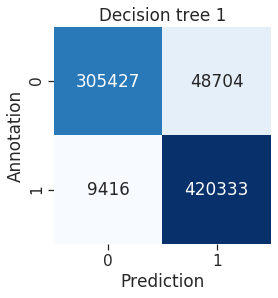

In [17]:
fig, ax = plt.subplots(figsize=(4, 4))

dt1 = pd.crosstab(arath_juncs.is_annot, arath_juncs.decision1)

sns.heatmap(dt1, ax=ax, cmap='Blues', square=True, cbar=False, annot=True, fmt='d')
ax.set_xticklabels([0, 1])
ax.set_yticklabels([0, 1])
ax.set_title('Decision tree 1')
ax.set_xlabel('Prediction')
ax.set_ylabel('Annotation')
plt.savefig('figures/arabidopsis_decision_tree_1_confusion_matrix.svg')
plt.show()

In [18]:
print(
    'Decision tree 1, Arabidopsis simulated data:\n'
    f'Accuracy score: {accuracy_score(arath_juncs.is_annot, arath_juncs.decision1):.3f}\n'
    f'F1 score: {f1_score(arath_juncs.is_annot, arath_juncs.decision1):.3f}\n'
    f'Precision: {precision_score(arath_juncs.is_annot, arath_juncs.decision1):.3f}\n'
    f'Recall score: {recall_score(arath_juncs.is_annot, arath_juncs.decision1):.3f}'
)

Decision tree 1, Arabidopsis simulated data:
Accuracy score: 0.926
F1 score: 0.935
Precision: 0.896
Recall score: 0.978


We next tested the data simulated from human samples to see how our decision tree/function performed

In [19]:
human_juncs = load_juncs('human_drs')
da = human_juncs.is_primary_donor & human_juncs.is_primary_acceptor
print(
    f'JAD metric F1 score: {f1_score(human_juncs.is_annot, human_juncs.jad >= 4):.3f}\n',
    f'Read count F1 score: {f1_score(human_juncs.is_annot, human_juncs["count"] > 1):.3f}\n',
    f'Canonical splice F1 score: {f1_score(human_juncs.is_annot, human_juncs.is_canon):.3f}\n',
    f'Primary donor metric F1 score: {f1_score(human_juncs.is_annot, human_juncs.is_primary_donor):.3f}\n',
    f'Primary acceptor metric F1 score: {f1_score(human_juncs.is_annot, human_juncs.is_primary_acceptor):.3f}\n',
    f'Primary donor/acceptor metric F1 score: {f1_score(human_juncs.is_annot, da):.3f}\n',
)

JAD metric F1 score: 0.868
 Read count F1 score: 0.818
 Canonical splice F1 score: 0.769
 Primary donor metric F1 score: 0.832
 Primary acceptor metric F1 score: 0.815
 Primary donor/acceptor metric F1 score: 0.930



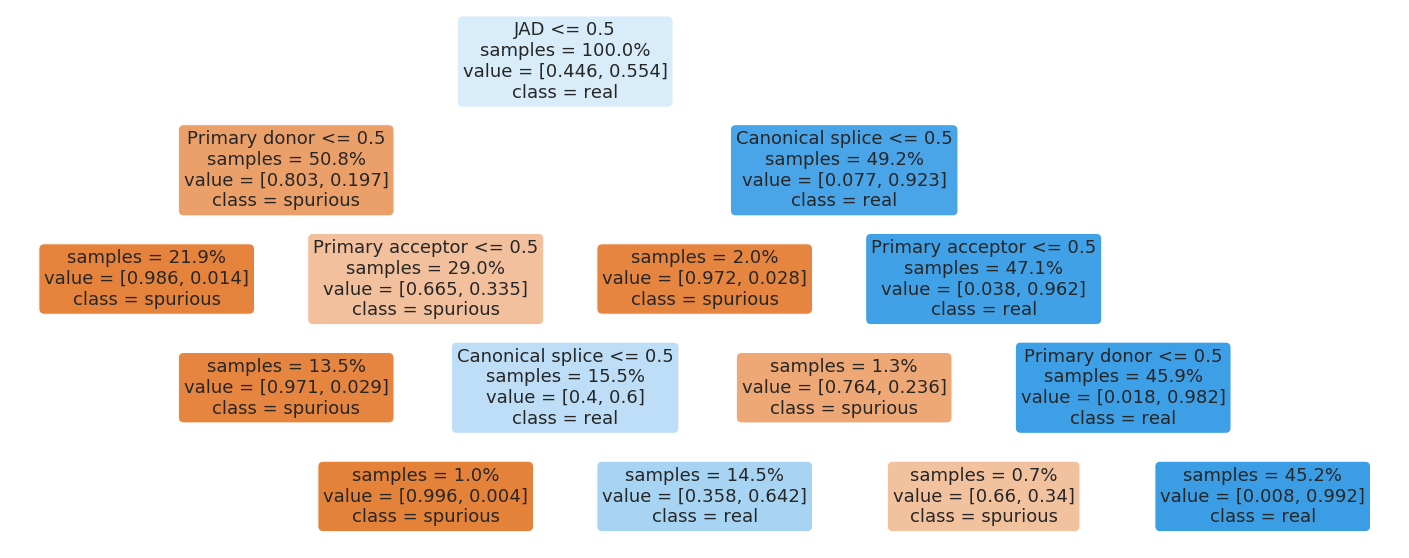

In [20]:
X_human = human_juncs[features].values.astype(float)
y_human = human_juncs.is_annot.values.astype(int)

dt_human = DecisionTreeClassifier(
    max_depth=4,
    min_samples_split=1000,
    min_impurity_decrease=0.005,
).fit(X_human, y_human)

fig, ax = plt.subplots(figsize=(25, 10))
plot_tree(
    dt_human,
    ax=ax,
    fontsize=18,
    feature_names=feature_names,
    filled=True,
    rounded=True,
    impurity=False,
    proportion=True,
    precision=3,
    class_names=['spurious', 'real']
)
plt.show()

The human data independently produces a very similar decision tree, therefore we chose to use the Arabidopsis tree as the first filtering step.

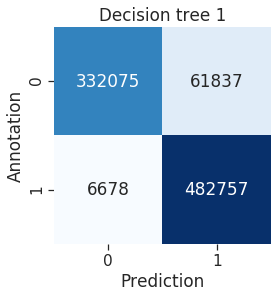

In [21]:
fig, ax = plt.subplots(figsize=(4, 4))

dt1 = pd.crosstab(human_juncs.is_annot, human_juncs.decision1)

sns.heatmap(dt1, ax=ax, cmap='Blues', square=True, cbar=False, annot=True, fmt='d')
ax.set_xticklabels([0, 1])
ax.set_yticklabels([0, 1])
ax.set_title('Decision tree 1')
ax.set_xlabel('Prediction')
ax.set_ylabel('Annotation')
plt.savefig('figures/human_decision_tree_1_confusion_matrix.svg')
plt.show()

In [22]:
print(
    'Decision tree 1, Human simulated data:\n'
    f'Accuracy score: {accuracy_score(human_juncs.is_annot, human_juncs.decision1):.3f}\n'
    f'F1 score: {f1_score(human_juncs.is_annot, human_juncs.decision1):.3f}\n'
    f'Precision: {precision_score(human_juncs.is_annot, human_juncs.decision1):.3f}\n'
    f'Recall score: {recall_score(human_juncs.is_annot, human_juncs.decision1):.3f}'
)

Decision tree 1, Human simulated data:
Accuracy score: 0.922
F1 score: 0.934
Precision: 0.886
Recall score: 0.986


### Decision tree 2:

We believed that a further improvement to the model might be made by learning the sequence bias of splice junctions. Splice junction sequences are known to be biased towards sequences that are complementary to the U1 and U2 snRNAs, amongst other snRNAs. These sequence biases are potentially species specific, however, and so cannot be built directly into the model.

Instead we use the predictions from the first model as outcome labels, and the sequences of the splices as predictors, and build a logistic regression model to learn the splice junction sequence. A donor or acceptor site is labelled as genuine if it participates in at least one junction which is considered genuine by the first model. This produces a model which can estimate splice junction strength from sequence alone:

![LR model](figures/sequence_lr_model_diagram.svg)

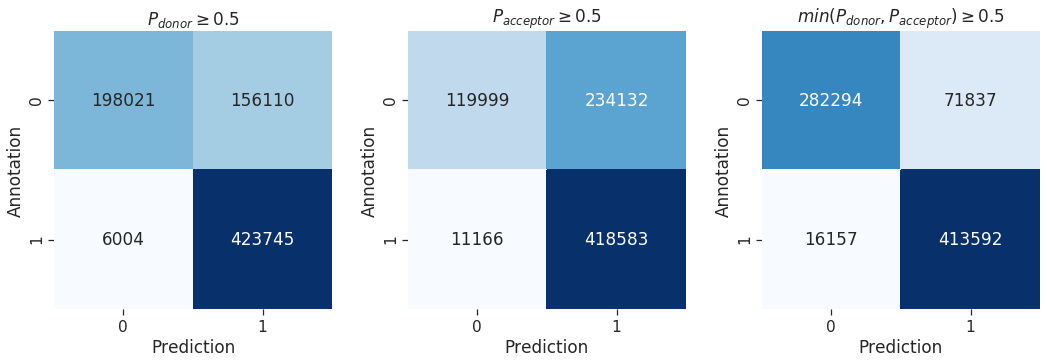

In [26]:
fig, axes = plt.subplots(figsize=(15, 5), ncols=3)

lr = pd.crosstab(arath_juncs.is_annot, arath_juncs.donor_seq_score >= 0.5)
sns.heatmap(lr, ax=axes[0], cmap='Blues', square=True, cbar=False, annot=True, fmt='d')
axes[0].set_xticklabels([0, 1])
axes[0].set_yticklabels([0, 1])
axes[0].set_title(r'$P_{donor} \geq 0.5$')
axes[0].set_xlabel('Prediction')
axes[0].set_ylabel('Annotation')

lr = pd.crosstab(arath_juncs.is_annot, arath_juncs.acceptor_seq_score >= 0.5)
sns.heatmap(lr, ax=axes[1], cmap='Blues', square=True, cbar=False, annot=True, fmt='d')
axes[1].set_xticklabels([0, 1])
axes[1].set_yticklabels([0, 1])
axes[1].set_title(r'$P_{acceptor} \geq 0.5$')
axes[1].set_xlabel('Prediction')
axes[1].set_ylabel('Annotation')


lr_score = (arath_juncs.donor_seq_score >= 0.5) & (arath_juncs.acceptor_seq_score >= 0.5)
lr = pd.crosstab(arath_juncs.is_annot, lr_score)
sns.heatmap(lr, ax=axes[2], cmap='Blues', square=True, cbar=False, annot=True, fmt='d')
axes[2].set_xticklabels([0, 1])
axes[2].set_yticklabels([0, 1])
axes[2].set_title(r'$min(P_{donor}, P_{acceptor}) \geq 0.5$')
axes[2].set_xlabel('Prediction')
axes[2].set_ylabel('Annotation')

plt.tight_layout()

plt.savefig('figures/arabidopsis_lr_scores_confusion_matrix.svg')
plt.show()

In [24]:
print(
    'Donor/acceptor LR score, Arabidopsis simulated data:\n'
    f'Accuracy score: {accuracy_score(arath_juncs.is_annot, lr_score):.3f}\n'
    f'F1 score: {f1_score(arath_juncs.is_annot, lr_score):.3f}\n'
    f'Precision: {precision_score(arath_juncs.is_annot, lr_score):.3f}\n'
    f'Recall score: {recall_score(arath_juncs.is_annot, lr_score):.3f}'
)

Donor/acceptor LR score, Arabidopsis simulated data:
Accuracy score: 0.888
F1 score: 0.904
Precision: 0.852
Recall score: 0.962


Using a threshold of 0.5, the combination of donor/acceptor scores gives an F1 score of 0.909, indicating that the sequence is very predictive of genuine splice junctions. We therefore considered whether the splice junction scores generated could be incorporated into our model 

In [25]:
features2 = [
    'count',
    'is_primary_donor', 'is_primary_acceptor',
    'jad_thresholded',
    'donor_seq_score', 'acceptor_seq_score'
]

feature_names2 = [
    'Read count',
    'Primary donor', 'Primary acceptor',
    'JAD',
    'Donor splice score', 'Acceptor splice score'
]

X_arath2 = arath_juncs[features2].values.astype(float)
y_arath2 = arath_juncs.is_annot.values.astype(int)

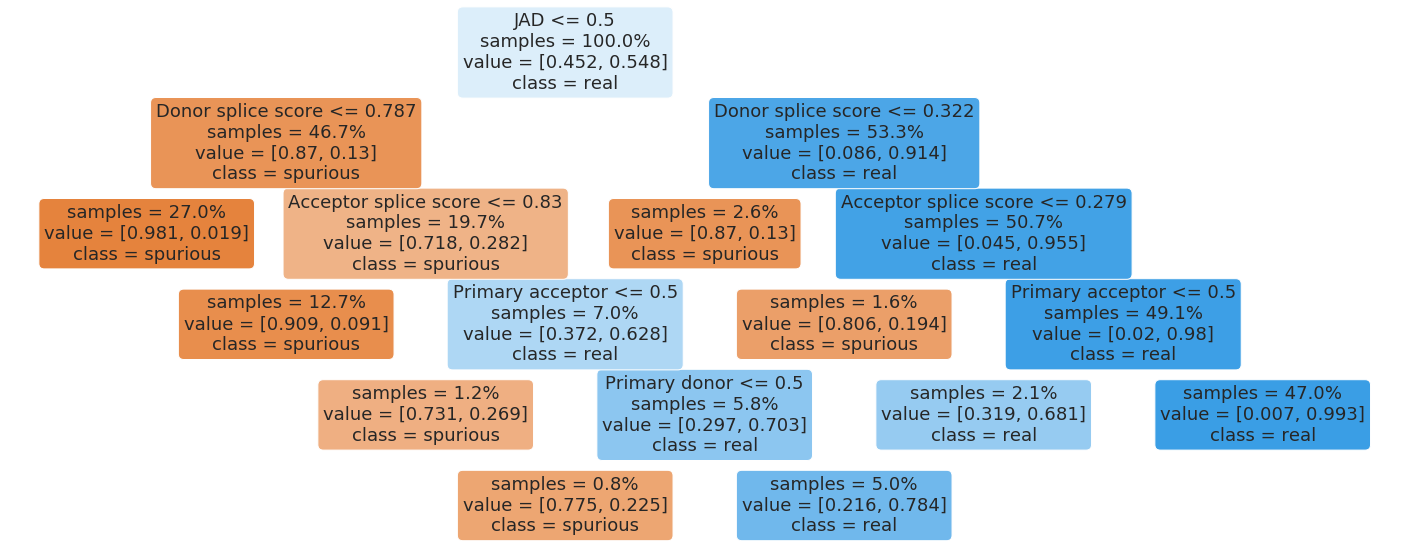

In [26]:
dt2_arath = DecisionTreeClassifier(
    max_depth=6,
    min_samples_split=1000,
    min_impurity_decrease=0.003,
).fit(X_arath2, y_arath2)

fig, ax = plt.subplots(figsize=(25, 10))
plot_tree(
    dt2_arath,
    ax=ax,
    fontsize=18,
    feature_names=feature_names2,
    filled=True,
    rounded=True,
    impurity=False,
    proportion=True,
    precision=3,
    class_names=['spurious', 'real']
)
plt.show()

In [27]:
dt2_rules = [
    'jad >= 4',
    [
        'is_primary_donor == 1',
        0,
        [
            'is_primary_acceptor == 1',
            0,
            [
                'donor_seq_score >= 0.6',
                0,
                [
                    'acceptor_seq_score >= 0.6',
                    0,
                    1,
                ],
            ],
        ],
    ],
    [
        'donor_seq_score >= 0.1',
        0,
        [
            'acceptor_seq_score >= 0.1',
            0,
            1,
        ],
    ],
]

In [28]:
stringify_tree(arath_juncs, 'is_annot', dt2_rules, ['Spurious', 'Real'])

jad >= 4 100.0% of junctions 54.8% Real 45.2% Spurious, #d2eaf9
	is_primary_donor == 1 46.7% of junctions 13.0% Real 87.0% Spurious, #d37f40
		Spurious 24.1% of junctions 1.5% Real 98.5% Spurious, #c55a0b
		is_primary_acceptor == 1 22.5% of junctions 25.3% Real 74.7% Spurious, #e1a577
			Spurious 12.3% of junctions 6.6% Real 93.4% Spurious, #cb6a22
			donor_seq_score >= 0.6 10.2% of junctions 47.9% Real 52.1% Spurious, #fcebde
				Spurious 2.4% of junctions 6.3% Real 93.7% Spurious, #cb6a22
				acceptor_seq_score >= 0.6 7.8% of junctions 60.9% Real 39.1% Spurious, #b8dcf1
					Spurious 1.3% of junctions 16.1% Real 83.9% Spurious, #d6884e
					Real 6.5% of junctions 69.6% Real 30.4% Spurious, #90c6e6
	donor_seq_score >= 0.1 53.3% of junctions 91.4% Real 8.6% Spurious, #2d90cb
		Spurious 2.1% of junctions 4.9% Real 95.1% Spurious, #c9651b
		acceptor_seq_score >= 0.1 51.3% of junctions 94.9% Real 5.1% Spurious, #1f89c7
			Spurious 1.2% of junctions 6.1% Real 93.9% Spurious, #ca6920
			Rea

This tree was simplified by pruning splits which do not alter the overall decision and simplifying the donor/acceptor splice score thresholds, to give the following overall tree structure which produces relatively balanced precision and recall:

![Decision tree 1](figures/arath_junc_decision_tree_2_final.svg)

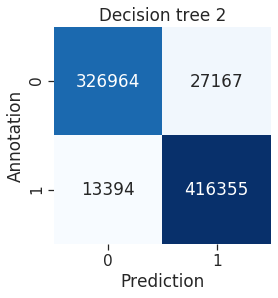

In [29]:
fig, ax = plt.subplots(figsize=(4, 4))

dt2 = pd.crosstab(arath_juncs.is_annot, arath_juncs.decision2)

sns.heatmap(dt2, ax=ax, cmap='Blues', square=True, cbar=False, annot=True, fmt='d')
ax.set_xticklabels([0, 1])
ax.set_yticklabels([0, 1])
ax.set_title('Decision tree 2')
ax.set_xlabel('Prediction')
ax.set_ylabel('Annotation')
plt.savefig('figures/arabidopsis_decision_tree_2_confusion_matrix.svg')
plt.show()

In [30]:
print(
    'Decision tree 2, Arabidopsis simulated data:\n'
    f'Accuracy score: {accuracy_score(arath_juncs.is_annot, arath_juncs.decision2):.3f}\n'
    f'F1 score: {f1_score(arath_juncs.is_annot, arath_juncs.decision2):.3f}\n'
    f'Precision: {precision_score(arath_juncs.is_annot, arath_juncs.decision2):.3f}\n'
    f'Recall score: {recall_score(arath_juncs.is_annot, arath_juncs.decision2):.3f}'
)

Decision tree 2, Arabidopsis simulated data:
Accuracy score: 0.948
F1 score: 0.954
Precision: 0.939
Recall score: 0.969


The second decision tree replaces the intron motif metric with the donor/acceptor sequence score metrics, and results in an improvement in the F1 score to 0.953 for the Arabidopsis junction data.

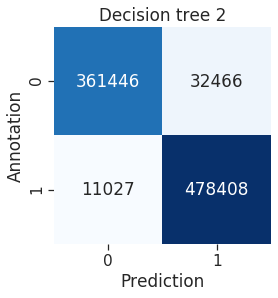

In [31]:
fig, ax = plt.subplots(figsize=(4, 4))

dt2 = pd.crosstab(human_juncs.is_annot, human_juncs.decision2)

sns.heatmap(dt2, ax=ax, cmap='Blues', square=True, cbar=False, annot=True, fmt='d')
ax.set_xticklabels([0, 1])
ax.set_yticklabels([0, 1])
ax.set_title('Decision tree 2')
ax.set_xlabel('Prediction')
ax.set_ylabel('Annotation')
plt.savefig('figures/human_decision_tree_2_confusion_matrix.svg')
plt.show()

In [32]:
print(
    'Decision tree 2, Human simulated data:\n'
    f'Accuracy score: {accuracy_score(human_juncs.is_annot, human_juncs.decision2):.3f}\n'
    f'F1 score: {f1_score(human_juncs.is_annot, human_juncs.decision2):.3f}\n'
    f'Precision: {precision_score(human_juncs.is_annot, human_juncs.decision2):.3f}\n'
    f'Recall score: {recall_score(human_juncs.is_annot, human_juncs.decision2):.3f}'
)

Decision tree 2, Human simulated data:
Accuracy score: 0.951
F1 score: 0.957
Precision: 0.936
Recall score: 0.977


The model also improves the F1 score for the human data to 0.957.